In [4]:
import os
import sys
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from torch_wavefunction_GP import *

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [2]:
class WavefunctionResults:
    def __init__(self):
        self.wavefunctions = []
        self.convergence_energies = []
        self.final_wavefunctions = []
        self.final_energies = []
        self.torch_wavefunctions = []

In [3]:
def train_single_state(results: WavefunctionResults, x_train,layout=[1,60,60,1], **kwargs):
    model = WaveFunctionMLP(layout).to(device)
    
    if "callback" in kwargs:
        callback_kwargs = kwargs["callback"]
        assert isinstance(callback_kwargs, dict), "callback_kwargs must be a dictionary"
    else:
        callback_kwargs = {}
    if "train" in kwargs:
        train_kwargs = kwargs["train"]
        assert isinstance(train_kwargs, dict), "train_kwargs must be a dictionary"
    else:
        train_kwargs = {}
    
    
    for key in kwargs:
        if ((key != "callback") and (key != "train")):
            print(f"Unknown keyword argument: {key}")
    
    if "patience" not in callback_kwargs:
        callback_kwargs['patience'] = 250
    if "min_delta" not in callback_kwargs:
        callback_kwargs['min_delta'] = 0.0001
        
    if "lr" not in train_kwargs:
        train_kwargs['lr'] = 0.001
    if "epochs" not in train_kwargs:
        train_kwargs['epochs'] = 1000
    if "save_wavefunction_history" not in train_kwargs:
        train_kwargs['save_wavefunction_history'] = False
    # if "save_energy_history" not in train_kwargs:
    #     train_kwargs['save_energy_history'] = False
    if "previous_wavefunctions" not in train_kwargs:
        train_kwargs['previous_wavefunctions'] = None
    
    early_stopping = EarlyStoppingCallback(patience = callback_kwargs['patience'], min_delta =  callback_kwargs['min_delta'])
    psi_normalized_cpu, energy_fin, energy_hist, wf_hist, psi_normalized_torch = train_wavefunction(model, 
                                                                                                    x_train, 
                                                                                                    callback=early_stopping, 
                                                                                                    **train_kwargs)
    results.wavefunctions.append(wf_hist)
    results.convergence_energies.append(energy_hist)
    results.final_wavefunctions.append(psi_normalized_cpu)
    results.final_energies.append(energy_fin)
    results.torch_wavefunctions.append(psi_normalized_torch)
    return True

In [34]:
x_train = torch.linspace(-10, 10, 1000, dtype=torch.float32, device=device).view(-1, 1)
x_train.requires_grad = True
results = WavefunctionResults()

callback_kwargs_0 = {
    "patience": 300,
    "min_delta": 1e-2,
    }
train_kwargs_0 = {
    "lr": 0.00005,
    "epochs": 30000,
    "save_wavefunction_history": True,
    # "save_energy_history": True,
    "previous_wavefunctions": None,
    }

options_0 = {
    "callback": callback_kwargs_0,
    "train": train_kwargs_0,
    }

train_single_state(results, x_train, layout=[1,7,1], boundary_conditions=True ,**options_0)


Unknown keyword argument: boundary_conditions
Epoch 0: Energy = 222.755051
Epoch 100: Energy = 208.599197
Epoch 200: Energy = 195.150543
Epoch 300: Energy = 182.371231
Epoch 400: Energy = 170.215881
Epoch 500: Energy = 158.638290
Epoch 600: Energy = 147.591202
Epoch 700: Energy = 137.027451
Epoch 800: Energy = 126.901642
Epoch 900: Energy = 117.169991
Epoch 1000: Energy = 107.789078
Epoch 1100: Energy = 98.716515
Epoch 1200: Energy = 89.914658
Epoch 1300: Energy = 81.363091
Epoch 1400: Energy = 73.086838
Epoch 1500: Energy = 65.201744
Epoch 1600: Energy = 57.942921
Epoch 1700: Energy = 51.636036
Epoch 1800: Energy = 46.574310
Epoch 1900: Energy = 42.858074
Epoch 2000: Energy = 40.338375
Epoch 2100: Energy = 38.713066
Epoch 2200: Energy = 37.668167
Epoch 2300: Energy = 36.960190
Epoch 2400: Energy = 36.430767
Epoch 2500: Energy = 35.988136
Epoch 2600: Energy = 35.583572
Epoch 2700: Energy = 35.192905
Epoch 2800: Energy = 34.804989
Epoch 2900: Energy = 34.415024
Epoch 3000: Energy = 34.0

True

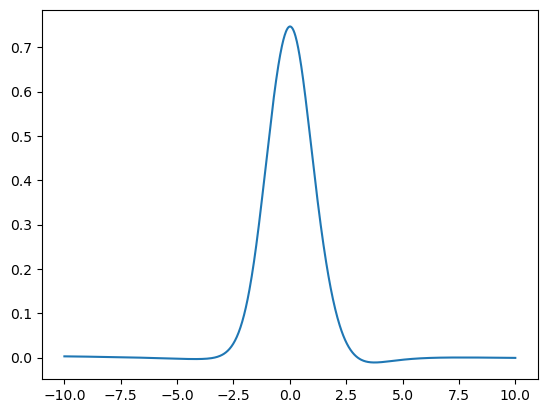

In [35]:
for final_wavefunction_cpu in results.final_wavefunctions:
    plt.plot(x_train.cpu().detach().numpy(), final_wavefunction_cpu, label="Final Wavefunction CPU")

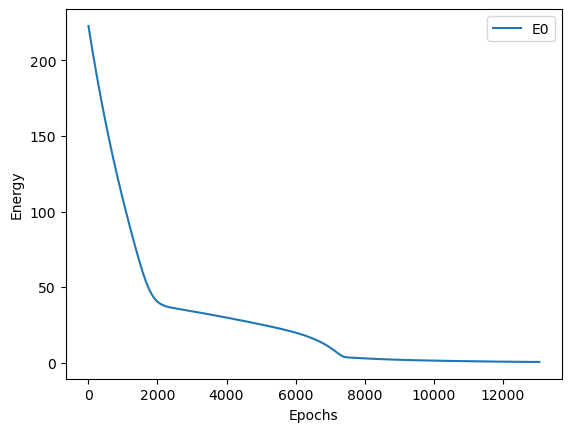

In [36]:
for i, energy_hist in enumerate(results.convergence_energies):
    plt.plot(energy_hist, label=f"E{i}")
plt.xlabel("Epochs")
plt.ylabel("Energy")
plt.legend()